In [ ]:
!pip install seaborn

In [1]:
import numpy as np
import pandas as pd
import random

from IntrinsicDim import PHD

from sklearn.utils import shuffle
from transformers import RobertaTokenizer, RobertaModel
import torch

from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

np.random.seed(42)
random.seed(42)

#import os
#os.environ["REQUESTS_CA_BUNDLE"] = "/etc/ssl/certs/ca-certificates.crt"
#os.environ["SSL_CERT_FILE"] = "/etc/ssl/certs/ca-certificates.crt"
import pickle as pk

In [2]:
DEVICE = "cuda:0"
MAX_LEN = 512
EXAMPLES_PER_DF = 250

In [3]:
reddit_path_gpt3 = "data/human_gpt3_davinci_003_reddit.json_pp"
wiki_path_gpt3 = "data/human_gpt3_davinci_003_wikip.zip"

In [4]:
df_gpt3_w = pd.read_json(wiki_path_gpt3, lines=True)
df_gpt3_r = pd.read_json(reddit_path_gpt3, lines=True)
df_gpt3_w = [df_gpt3_w[i][0] for i in range(len(df_gpt3_w.columns))]
df_gpt3_r = [df_gpt3_r[i][0] for i in range(len(df_gpt3_r.columns))]
df_gpt3_w = df_gpt3_w[:EXAMPLES_PER_DF]
df_gpt3_r = df_gpt3_r[:EXAMPLES_PER_DF]
len(df_gpt3_r), len(df_gpt3_w)

(250, 250)

In [5]:
print(df_gpt3_r[0].keys())

dict_keys(['prefix', 'gold_completion', 'gen_completion', 'paraphrase_outputs', 'split'])


In [27]:
text_sets = {
    "gpt_w_3_paraphrase_40_40_input":list(map(lambda x: x['paraphrase_outputs']['lex_40_order_40']['final_input'], df_gpt3_w)),
    "gpt_w_3_paraphrase_40_40_output":list(map(lambda x: x['paraphrase_outputs']['lex_40_order_40']['output'][0], df_gpt3_w)),
    "gpt_w_3_paraphrase_40_100_input":list(map(lambda x: x['paraphrase_outputs']['lex_40_order_100']['final_input'], df_gpt3_w)),
    "gpt_w_3_paraphrase_40_100_output":list(map(lambda x: x['paraphrase_outputs']['lex_40_order_100']['output'][0], df_gpt3_w)),
    "gpt_w_3_paraphrase_80_100_input":list(map(lambda x: x['paraphrase_outputs']['lex_80_order_100']['final_input'], df_gpt3_w)),
    "gpt_w_3_paraphrase_80_100_output":list(map(lambda x: x['paraphrase_outputs']['lex_80_order_100']['output'][0], df_gpt3_w)),
    
    "gpt_r_3_paraphrase_40_40_input":list(map(lambda x: x['paraphrase_outputs']['lex_40_order_40']['final_input'], df_gpt3_r)),
    "gpt_r_3_paraphrase_40_40_output":list(map(lambda x: x['paraphrase_outputs']['lex_40_order_40']['output'][0], df_gpt3_r)),
    "gpt_r_3_paraphrase_40_100_input":list(map(lambda x: x['paraphrase_outputs']['lex_40_order_100']['final_input'], df_gpt3_r)),
    "gpt_r_3_paraphrase_40_100_output":list(map(lambda x: x['paraphrase_outputs']['lex_40_order_100']['output'][0], df_gpt3_r)),
    "gpt_r_3_paraphrase_80_100_input":list(map(lambda x: x['paraphrase_outputs']['lex_80_order_100']['final_input'], df_gpt3_r)),
    "gpt_r_3_paraphrase_80_100_output":list(map(lambda x: x['paraphrase_outputs']['lex_80_order_100']['output'][0], df_gpt3_r)),
}

In [29]:
text_sets["gpt_r_3_paraphrase_40_40_input"][2]

"lexical = 40, order = 40 Answer the following question in 200-250 words. Q: Why can't you live off of suplements? A: Supplements usually contain one or two nutrients, such as vitamins, minerals, or amino acids. Supplements are no substitute for a balanced diet. Moreover, many supplements contain preservatives, synthetic dyes, and other harmful substances. This means that to get the same nutrients from a balanced diet, you have to take many supplements. The dose of each nutrient you get from a supplement will probably be much lower than from a food source. Moreover, a balanced diet gives you a large number of vitamins, minerals, and other nutrients that supplements do not contain. Moreover, a balanced diet will provide you with the best opportunity for a healthy life. Finally, the body needs a wide variety of nutrients to function properly. When taken in large doses, these substances can lead to unwanted health problems, such as digestive disorders and imbalances in the body. <sent> Fu

In [11]:
### Insert here path to model files in your system
model_path = 'roberta-base'
tokenizer_path = model_path

### Loading the model
tokenizer = RobertaTokenizer.from_pretrained(tokenizer_path)
model = RobertaModel.from_pretrained(model_path)

C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
"""
Our method (PHD) is stochastic, here are some magic constants for it. They are chosen specifically for text data. If you plan to use this code for something different, consider testing other values.

MIN_SUBSAMPLE       --- the size of the minimal subsample to be drawn in procedure. Lesser values yields less statisitcally stable predictions.
INTERMEDIATE_POINTS --- number of sumsamples to be drawn. The more this number is, the more stable dimension estimation for single text is; however,  the computational time is higher, too. 7 is, empirically, the best trade-off.
"""
MIN_SUBSAMPLE = 40
INTERMEDIATE_POINTS = 7

In [30]:
'''
Auxillary function. Clear text from linebreaks and odd whitespaces, because they seem to interfer with LM quite a lot.
Replace with a more sophisticated cleaner, if needed.
'''

def preprocess_text(text):
    return text.replace('\n', ' ').replace('  ', ' ')

In [31]:
'''
Get PHD for one text
Parameters:
        text  --- text
        solver --- PHD computator

Returns:
    real number or NumPy.nan  --- Intrinsic dimension value of the text in the input data
                                                    estimated by Persistence Homology Dimension method.'''
def get_phd_single(text, solver):
    inputs = tokenizer(preprocess_text(text), truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        outp = model(**inputs)

    # We omit the first and last tokens (<CLS> and <SEP> because they do not directly correspond to any part of the)
    mx_points = inputs['input_ids'].shape[1] - 2


    mn_points = MIN_SUBSAMPLE
    step = ( mx_points - mn_points ) // INTERMEDIATE_POINTS

    return solver.fit_transform(outp[0][0].numpy()[1:-1],  min_points=mn_points, max_points=mx_points - step, \
                                point_jump=step)

In [73]:
phds = {}
for key in text_sets.keys():
    phds[key] = []
    PHD_solver = PHD(metric='euclidean', n_points=3)
    for text in tqdm(text_sets[key], desc=key):
        try:
            phds[key].append(get_phd_single(text, PHD_solver))
        except Exception as e:
            print(e)
            phds[key].append(0)
    print(f"{key}: mean = {np.mean(phds[key])}, std = {np.std(phds[key])}")

gpt_w_3_paraphrase_40_40_input: 100%|████████████████████████████████████████████████████████████████████| 250/250 [02:28<00:00,  1.68it/s]


gpt_w_3_paraphrase_40_40_input: mean = 7.753966012968105, std = 1.279347530681689


gpt_w_3_paraphrase_40_40_output:  16%|██████████▉                                                         | 40/250 [00:16<00:59,  3.50it/s]

range() arg 3 must not be zero


gpt_w_3_paraphrase_40_40_output:  22%|██████████████▉                                                     | 55/250 [00:21<01:11,  2.72it/s]Exception in thread Thread-6259 (_calc_ph_dim_single):
Traceback (most recent call last):
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
Exception in thread Thread-6260 (_calc_ph_dim_single):
Traceback (most recent call last):
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
Exception in thread Thread-6261 (_calc_ph_dim_single):
Traceback (most recent call last):
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self.run()
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self.run()
  File "C

range() arg 3 must not be zero


gpt_w_3_paraphrase_40_40_output:  36%|████████████████████████▍                                           | 90/250 [00:33<00:57,  2.79it/s]

range() arg 3 must not be zero


gpt_w_3_paraphrase_40_40_output:  38%|█████████████████████████▌                                          | 94/250 [00:34<01:10,  2.21it/s]Exception in thread Thread-6370 (_calc_ph_dim_single):
Traceback (most recent call last):
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
Exception in thread Thread-6371 (_calc_ph_dim_single):
Traceback (most recent call last):
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
Exception in thread Thread-6372 (_calc_ph_dim_single):
Traceback (most recent call last):
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._

ValueError: Cannot take a larger sample than population when 'replace=False'
ValueError: Cannot take a larger sample than population when 'replace=False'
gpt_w_3_paraphrase_40_40_output:  54%|████████████████████████████████████▏                              | 135/250 [00:51<00:57,  2.01it/s]Exception in thread Thread-6493 (_calc_ph_dim_single):
Traceback (most recent call last):
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
Exception in thread Thread-6494 (_calc_ph_dim_single):
Traceback (most recent call last):
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
Exception in thread Thread-6495 (_calc_ph_dim_single):
Traceback (most recent call last):
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _

range() arg 3 must not be zero


gpt_w_3_paraphrase_40_40_output:  63%|██████████████████████████████████████████▎                        | 158/250 [01:01<00:35,  2.63it/s]Exception in thread Thread-6559 (_calc_ph_dim_single):
Traceback (most recent call last):
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
Exception in thread Thread-6560 (_calc_ph_dim_single):
Traceback (most recent call last):
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
Exception in thread Thread-6561 (_calc_ph_dim_single):
Traceback (most recent call last):
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self.run()
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self.run()
  File "C

ValueError: Cannot take a larger sample than population when 'replace=False'
ValueError: Cannot take a larger sample than population when 'replace=False'
gpt_w_3_paraphrase_40_40_output:  83%|███████████████████████████████████████████████████████▋           | 208/250 [01:18<00:15,  2.76it/s]Exception in thread Thread-6709 (_calc_ph_dim_single):
Traceback (most recent call last):
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
Exception in thread Thread-6710 (_calc_ph_dim_single):
Traceback (most recent call last):
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
Exception in thread Thread-6711 (_calc_ph_dim_single):
Traceback (most recent call last):
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", l

range() arg 3 must not be zero


gpt_w_3_paraphrase_40_40_output:  90%|████████████████████████████████████████████████████████████▌      | 226/250 [01:25<00:12,  1.92it/s]

range() arg 3 must not be zero


gpt_w_3_paraphrase_40_40_output:  92%|█████████████████████████████████████████████████████████████▉     | 231/250 [01:26<00:07,  2.59it/s]Exception in thread Thread-6772 (_calc_ph_dim_single):
Traceback (most recent call last):
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
Exception in thread Thread-6773 (_calc_ph_dim_single):
Traceback (most recent call last):
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
Exception in thread Thread-6774 (_calc_ph_dim_single):
Traceback (most recent call last):
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self.run()
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self.run()
  File "C

gpt_w_3_paraphrase_40_40_output: mean = nan, std = nan


gpt_w_3_paraphrase_40_100_input: 100%|███████████████████████████████████████████████████████████████████| 250/250 [02:42<00:00,  1.54it/s]


gpt_w_3_paraphrase_40_100_input: mean = 7.854320046085386, std = 1.211131808044493


gpt_w_3_paraphrase_40_100_output:   5%|███▏                                                               | 12/250 [00:03<01:07,  3.50it/s]

range() arg 3 must not be zero


gpt_w_3_paraphrase_40_100_output:  22%|██████████████▋                                                    | 55/250 [00:22<01:19,  2.44it/s]Exception in thread Thread-7741 (_calc_ph_dim_single):
Traceback (most recent call last):
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
Exception in thread Thread-7742 (_calc_ph_dim_single):
Traceback (most recent call last):
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
Exception in thread Thread-7743 (_calc_ph_dim_single):
Traceback (most recent call last):
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self.run()
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._

range() arg 3 must not be zero


gpt_w_3_paraphrase_40_100_output:  38%|█████████████████████████▏                                         | 94/250 [00:37<01:31,  1.70it/s]Exception in thread Thread-7855 (_calc_ph_dim_single):
Traceback (most recent call last):
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
Exception in thread Thread-7856 (_calc_ph_dim_single):
Traceback (most recent call last):
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
Exception in thread Thread-7857 (_calc_ph_dim_single):
Traceback (most recent call last):
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self.run()
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self.run()
  File "C

ValueError: Cannot take a larger sample than population when 'replace=False'
ValueError: Cannot take a larger sample than population when 'replace=False'
gpt_w_3_paraphrase_40_100_output:  46%|██████████████████████████████▌                                   | 116/250 [00:46<00:30,  4.33it/s]

range() arg 3 must not be zero


gpt_w_3_paraphrase_40_100_output:  53%|██████████████████████████████████▊                               | 132/250 [00:52<00:36,  3.26it/s]

range() arg 3 must not be zero


gpt_w_3_paraphrase_40_100_output:  54%|███████████████████████████████████▉                              | 136/250 [00:54<00:44,  2.57it/s]

range() arg 3 must not be zero


gpt_w_3_paraphrase_40_100_output:  61%|████████████████████████████████████████▏                         | 152/250 [01:03<00:43,  2.27it/s]

range() arg 3 must not be zero


gpt_w_3_paraphrase_40_100_output:  64%|█████████████████████████████████████████▉                        | 159/250 [01:06<00:32,  2.83it/s]

range() arg 3 must not be zero


gpt_w_3_paraphrase_40_100_output:  65%|██████████████████████████████████████████▊                       | 162/250 [01:07<00:21,  4.09it/s]

range() arg 3 must not be zero


gpt_w_3_paraphrase_40_100_output:  68%|█████████████████████████████████████████████▏                    | 171/250 [01:11<00:28,  2.73it/s]

range() arg 3 must not be zero


gpt_w_3_paraphrase_40_100_output:  76%|█████████████████████████████████████████████████▉                | 189/250 [01:20<00:26,  2.33it/s]

range() arg 3 must not be zero


gpt_w_3_paraphrase_40_100_output:  91%|███████████████████████████████████████████████████████████▉      | 227/250 [01:37<00:10,  2.26it/s]

range() arg 3 must not be zero


gpt_w_3_paraphrase_40_100_output:  95%|██████████████████████████████████████████████████████████████▊   | 238/250 [01:42<00:04,  2.68it/s]

range() arg 3 must not be zero


gpt_w_3_paraphrase_40_100_output:  97%|███████████████████████████████████████████████████████████████▉  | 242/250 [01:44<00:02,  2.70it/s]

range() arg 3 must not be zero


gpt_w_3_paraphrase_40_100_output: 100%|██████████████████████████████████████████████████████████████████| 250/250 [01:48<00:00,  2.31it/s]


gpt_w_3_paraphrase_40_100_output: mean = nan, std = nan


gpt_w_3_paraphrase_80_100_input: 100%|███████████████████████████████████████████████████████████████████| 250/250 [02:50<00:00,  1.47it/s]


gpt_w_3_paraphrase_80_100_input: mean = 7.636531354302357, std = 1.2474952483064405


gpt_w_3_paraphrase_80_100_output:  34%|██████████████████████▌                                            | 84/250 [00:37<01:13,  2.25it/s]Exception in thread Thread-9292 (_calc_ph_dim_single):
Traceback (most recent call last):
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
Exception in thread Thread-9293 (_calc_ph_dim_single):
Traceback (most recent call last):
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
Exception in thread Thread-9294 (_calc_ph_dim_single):
Traceback (most recent call last):
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self.run()
  File "C:\Users\melko\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._

ValueError: Cannot take a larger sample than population when 'replace=False'
gpt_w_3_paraphrase_80_100_output:  53%|██████████████████████████████████▊                               | 132/250 [01:00<00:38,  3.09it/s]

range() arg 3 must not be zero


gpt_w_3_paraphrase_80_100_output:  83%|██████████████████████████████████████████████████████▉           | 208/250 [01:36<00:14,  2.88it/s]

range() arg 3 must not be zero


gpt_w_3_paraphrase_80_100_output: 100%|██████████████████████████████████████████████████████████████████| 250/250 [01:54<00:00,  2.19it/s]


gpt_w_3_paraphrase_80_100_output: mean = 7.501491237410064, std = 1.9603303641652485


gpt_r_3_paraphrase_40_40_input: 100%|████████████████████████████████████████████████████████████████████| 250/250 [03:09<00:00,  1.32it/s]


gpt_r_3_paraphrase_40_40_input: mean = 7.640281254207586, std = 0.8868345447990534


gpt_r_3_paraphrase_40_40_output: 100%|███████████████████████████████████████████████████████████████████| 250/250 [02:22<00:00,  1.76it/s]


gpt_r_3_paraphrase_40_40_output: mean = 7.336216495307494, std = 1.0377623742395488


gpt_r_3_paraphrase_40_100_input: 100%|███████████████████████████████████████████████████████████████████| 250/250 [03:17<00:00,  1.27it/s]


gpt_r_3_paraphrase_40_100_input: mean = 7.645288644189524, std = 0.8996865839948587


gpt_r_3_paraphrase_40_100_output: 100%|██████████████████████████████████████████████████████████████████| 250/250 [02:35<00:00,  1.61it/s]


gpt_r_3_paraphrase_40_100_output: mean = 7.327305180877136, std = 0.9476878996936813


gpt_r_3_paraphrase_80_100_input: 100%|███████████████████████████████████████████████████████████████████| 250/250 [03:39<00:00,  1.14it/s]


gpt_r_3_paraphrase_80_100_input: mean = 7.579233788321961, std = 0.8320184868895738


gpt_r_3_paraphrase_80_100_output: 100%|██████████████████████████████████████████████████████████████████| 250/250 [02:57<00:00,  1.41it/s]

gpt_r_3_paraphrase_80_100_output: mean = 7.431388434692017, std = 1.0210299246983128


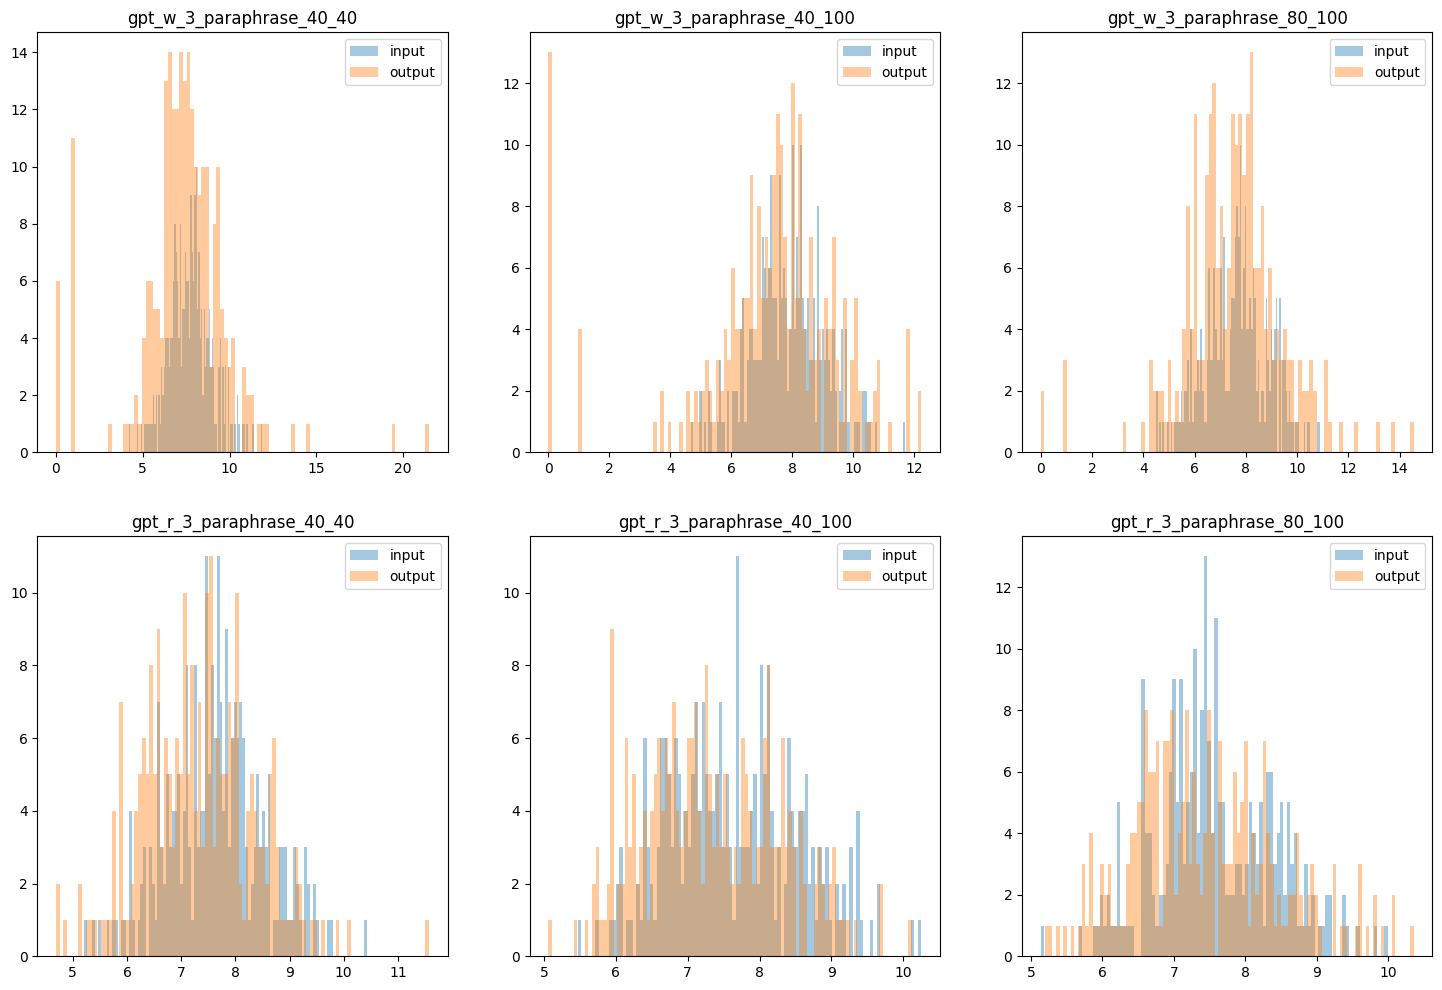

In [74]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))

for i, name in enumerate([
    'gpt_w_3_paraphrase_40_40',
    'gpt_r_3_paraphrase_40_100',
    'gpt_w_3_paraphrase_80_100',
    'gpt_r_3_paraphrase_40_40',
    'gpt_w_3_paraphrase_40_100',
    'gpt_r_3_paraphrase_80_100']):
    try:
        ax[i % 2, i % 3].set_title(name)
        ax[i % 2, i % 3].hist(phds[f'{name}_input'], bins=100, alpha=0.4, label="input")
        ax[i % 2, i % 3].hist(phds[f'{name}_output'], bins=100, alpha=0.4, label="output")
        ax[i % 2, i % 3].legend()
        
    except:
        print(phds[f'{name}_input'])
        print(phds[f'{name}_output'])

plt.show()